# OntologyTerms.ipynb
This notebook processes the results of querying the BioPortal API for for ontology terms matching conditions listed in ClinicalTrials.gov records.

The Java code which queries the API (referred to as the TermValidator) is located at https://github.com/lauramiron/metadata-analysis-tools.  Original code for the TermValidator is by Rafael Goncalves.  Slight modifications to input and output file parsing, and for returning all matching terms rather than only 1st page of best matches made by Laura Miron.

In [1]:
from lxml import etree
from io import StringIO
import sys, re, os, pdb, pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

root_data_dir = '/Users/lauramiron/Large_files/CTData/'
xml_dir = root_data_dir+'AllPublicXML/'
results_dir = 'results/'
val_results_csv = results_dir+'xml_val_results.csv'
xml_files = [os.path.join(root, f) for root, dirs, files in os.walk(xml_dir) for f in files if f.split('.')[1]=='xml']
NUM_RECORDS = len(xml_files)
print_progress=True

In [2]:
'''Utility Functions'''
# get list of ontology abbreviations in the 2019 version of the UMLS Metathesaurus
def _umls_ontos():
    lines = []
    with open('umls_ontos.txt') as f:
        lines = [l.strip() for l in f.readlines()]
    return lines

# Parse normalized abbreviation for source ontology from URI
# Deal with multiple styles of encoding term id and ontology in URI
def _row_to_ontology(row):
    url = row['url']
    if pd.isnull(url): return None
    url = url.strip()
    
    # e.g., http://purl.bioontology.org/ontology/MEDDRA/10012401
    if url.startswith('http://purl.bioontology.org/ontology'):
        return _normalize_abbrev(url.split('/')[-2])
    
    # e.g., http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl#C34918
    if url.startswith('http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl'):
        end = url.split('#')[-1]
        if re.match('^C\d*$',end) != None:
            return 'NCIT'

    last = url.split('/')[-1]
    if url.startswith('http://purl.obolibrary.org/obo'):
        # e.g., http://purl.obolibrary.org/obo/DDO.owl#DDO_0003036
        if ('_' in last) and ('#' in last):
            return _normalize_abbrev(last.split('#')[-1].split('_')[0])
        
        # e.g., http://purl.obolibrary.org/obo/ODGI.owl#Healthy
        if '#' in last:
            return _normalize_abbrev(last.split('#')[0].split('.')[0])    
        
        # e.g., http://purl.obolibrary.org/obo/CCTO_000225
        if ('_' in last):
            return _normalize_abbrev(last.split('_')[0])

    # e.g., http://www.ebi.ac.uk/efo/EFO_0003761
    if ('_' in last) and ('#' not in last):
        return _normalize_abbrev(last.split('_')[0])

    # e.g., http://purl.jp/bio/4/id/200906022166120721
    if 'purl.jp/bio/4' in url:
        return 'IOBC'
    
    # e.g., http://localhost/plosthes.2017-1#8591
    if 'plosthes' in url:
        return 'PLOSTHES'
    return False # non-null match that could not be parsed


# normalize mulitple abbreviations for the same ontology
# choice of 'correct' abbreviation is arbitrary
def _normalize_abbrev(onto):
    if onto == 'MESH':
        return 'MSH'
    if onto == 'LOINC':
        return 'LNC'
    if onto == 'MEDDRA':
        return 'MDR'
    return onto

### Number of conditions matching a term in each UMLS ontology
TermValidator takes as input condition.csv, a list of all conditions from CT.gov records, and outputs `condition_matches.csv`.  The following code performs analyses on `condition_matches.csv`.

In [49]:
df = pd.read_pickle('data/condition_matches.p') # pickled version of condition_matches.csv
df['ontology'] = df.apply(lambda row: _row_to_ontology(row),axis=1)

num_conditions = df.iloc[-1]['fid']
print(f"Num conditions: {num_conditions}")

Num conditions: 497124


In [51]:
# read list of ontologies included in 2019 UMLS metathesaurus
umls_ontos = _umls_ontos()

# filter full condition matches dataframe to only rows with a match to a term from a UMLS ontology
df_umls = df[(~df['ontology'].isnull()) & (df['ontology'].isin(umls_ontos))]

# Some ontologies in BioPortal import terms from other ontologies, which BioPortal returns as separate matches
# get rid of these duplicates
df_umls = df_umls.drop_duplicates(subset=['fid','ontology'])
df_umls_counts = df_umls['ontology'].value_counts().rename('Count')
df_umls_pct = (df_umls_counts / float(num_conditions)).rename('Pct')

print(f"Numbers of conditions with matches in each UMLS ontology")
df_umls_combined = pd.concat([df_umls_counts,df_umls_pct],axis=1)
display(df_umls_combined.style.format({
    'Pct': '{:,.2%}'.format
}))

num_matched_any = df_umls.loc[df_umls['ontology'].notnull()]['fid'].nunique()
print(f"Num conditions matched to any UMLS ontology: {num_matched_any}, {float(num_matched_any)/num_conditions:.2%}")

,Count,Pct
MSH,306197,61.59%
MDR,230639,46.39%
SNOMEDCT,224008,45.06%
CSP,169631,34.12%
NDFRT,167666,33.73%
OMIM,152262,30.63%
MEDLINEPLUS,151878,30.55%
RCD,150787,30.33%
LNC,132719,26.70%
ICPC2P,105572,21.24%


Num conditions matched to any UMLS ontology: 402875, 81.04%


### How many conditions are in MeSH?

In [16]:
mesh_cids = df_umls.loc[df_umls['ontology']=='MSH']['fid']
num_mesh_matched = mesh_cids.nunique()
num_mesh_unmatched = num_conditions - num_mesh_matched

df_mesh_unmatched = df_umls.loc[~df_umls['fid'].isin(mesh_cids)]
num_matched_other = df_mesh_unmatched['fid'].nunique()

print(f"Of {num_mesh_unmatched} conditions with no match in MeSH, {num_matched_other} ({float(num_matched_other)/num_mesh_unmatched:.2%}) have exact matches in other UMLS ontologies")

num_matched = df_umls['fid'].nunique()
print(f'Conditions matched to some umls: {num_matched}/{num_conditions}, {float(num_matched/num_conditions):.2%}')

Of 190927 conditions with no match in MeSH, 96678 (50.64%) have exact matches in other UMLS ontologies
Conditions matched to some umls: 402875/497124, 81.04%


#### Reproduce Figure 3

Conditions matched to some umls: 402875/497124, 81.04%


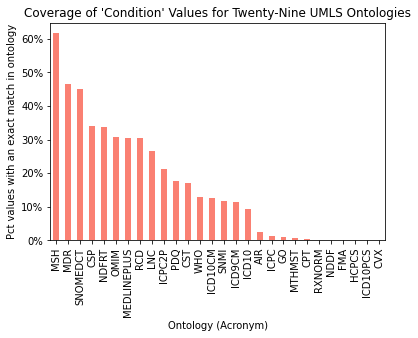

In [15]:
onto_counts = df_umls['ontology'].value_counts() / num_conditions
ax = onto_counts.plot.bar(color='salmon')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.title('Coverage of \'Condition\' Values for Twenty-Nine UMLS Ontologies')
plt.ylabel('Pct values with an exact match in ontology')
plt.xlabel('Ontology (Acronym)')
plt.savefig("results/figure3.eps",format='eps',bbox_inches = "tight")

### Intervention

In [32]:
df = pd.read_csv('data/intervention_matches.csv',sep='\t',header=None,index_col=False,names=['iid','intervention','url','match_term','cuis','tuis'])

num_interventions = df.iloc[-1]['iid']
print(f'Found {num_interventions} interventioned in CT.gov records')

num_matched = df[(~df['url'].isnull())]['iid'].nunique()
print(f'Found ontology matches for {num_matched} ({float(num_matched)/num_interventions:.2%}) of intervention terms')

Found 557436 interventioned in CT.gov records
Found ontology matches for 256463 (46.01%) of intervention terms


In [46]:
df_uniq = df.drop_duplicates(subset=['iid'])
df_uniq = df_uniq.set_index(['iid'],drop=True)
df_uniq['no_match'] = df_uniq[['url']].applymap(lambda x: (pd.isnull(x)))
group_results = df_uniq.groupby(['intervention_type'])['no_match'].sum()
group_results = 1-(group_results / df_uniq.groupby(['intervention_type'])['intervention'].count())
print(group_results)

intervention_type
Behavioral             0.249853
Biological             0.436618
Combination Product    0.162592
Device                 0.185469
Diagnostic Test        0.309598
Dietary Supplement     0.442313
Drug                   0.635356
Genetic                0.665074
Other                  0.396097
Procedure              0.413808
Radiation              0.613974
dtype: float64


#### Reproduce Figure 4

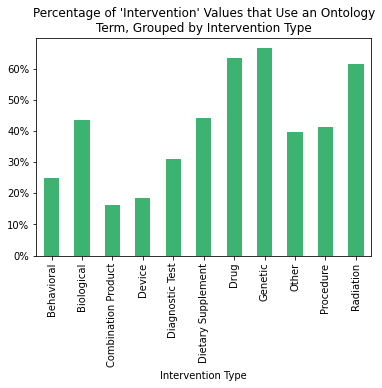

In [47]:
ax = group_results.plot.bar(color='mediumseagreen')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.xlabel('Intervention Type')
plt.title("\n".join(wrap('Percentage of \'Intervention\' Values that Use an Ontology Term, Grouped by Intervention Type',width=60)))
plt.savefig("results/figure4.eps",format='eps',bbox_inches = "tight")